In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import pprint
import sncosmo

/usr/local/manual/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
import sniacatalogs as sia
from lsst.sims.photUtils import Bandpass
from lsst.sims.photUtils import BandpassDict

# Load some stuff not directly connected to SNObject

#### LSST BandpassDicts

These are imported from `lsst.sims.photUtils.BandPassDict` and form an ordered dict of BandPass Instances for names.

In [4]:
bandpassnames = ['u', 'g', 'r', 'i', 'z', 'y']
LSST_BandPass = BandpassDict.loadTotalBandpassesFromFiles()

These bandpasses will be used as examples to obtain fluxes, and magnitudes. Also bandpass instances have an attribute `wavelen`, which are useful grids to obtain SEDs on. However, note that the grid is really too fine in comparison to the grid for SN models and will only serve to slow down flux calculations without helping accuracy. 

In [5]:
bpwavelengrid = LSST_BandPass['u'].wavelen
print(bpwavelengrid)

[  300.    300.1   300.2 ...,  1149.8  1149.9  1150. ]


In [6]:
BP, HBP = BandpassDict.loadBandpassesFromFiles()

In [7]:
def plotBandPasses(bandpassDict, logscale=False, ax=None, fig=None,
                   label=None, **kwargs):
    if fig is None:
        fig, ax = plt.subplots()
    ax.plot(bandpassDict['u'].wavelen, bandpassDict['u'].sb, label=label, **kwargs)
    ax.plot(bandpassDict['g'].wavelen, bandpassDict['g'].sb, **kwargs)
    ax.plot(bandpassDict['g'].wavelen, bandpassDict['r'].sb, **kwargs)
    ax.plot(bandpassDict['g'].wavelen, bandpassDict['i'].sb, **kwargs)
    ax.plot(bandpassDict['g'].wavelen, bandpassDict['z'].sb, **kwargs)
    ax.plot(bandpassDict['g'].wavelen, bandpassDict['y'].sb, **kwargs)
    if logscale:
        ax.set_yscale('log')
    ax.set_ylim(ymin=1.0e-6)
    return fig

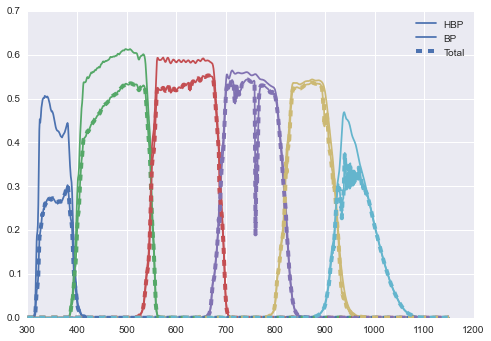

In [8]:
lstyle = dict()
lstyle['linestyle'] = '--'
lstyle['lw'] = 4.
fig = plotBandPasses(HBP, label='HBP')
fig = plotBandPasses(BP, fig=fig, ax=fig.axes[0], label='BP')
fig = plotBandPasses(LSST_BandPass, fig=fig, ax=fig.axes[0], label='Total',**lstyle)
plt.legend(loc='best')

# The SNObject

The SNObject is a class which contains a complete characterization (to the extent we have it in CatSim) of a supernova. It contains methods for returning a time dependent SED in the observer frame of the earth at the top of the earth's atmosphere with MW and potentially (host galaxy) extinction.

## Instantiation Alternatives

An instance may be created and built up in multiple ways:
1. Want to obtain a SN at some coordinates (to match up with host), but want to control MW extinction: Instantiate the SN with no parameters, and then set model parameters. Then set your desired value of MW extinction. 
2. Instantiate it with coordinates, and the object already knows its MW extinction using the dustmaps
3. Instantiate it without coordinates, but set those later (as in a), but then decide to use the calculated values of extinction.

In [9]:
SN_blank = sia.snObject.SNObject()
SN_blank.setCoords(ra=30., dec=-60.)
SN_blank.set(z=0.96, t0=571181, x1=2.66, c=0.353, x0=1.796e-6)

In [10]:
print SN_blank.ebvofMW

None


This will prevent you from doing any real calculations with the SED, as a reminder that the extinction has not been set.
However, you can set it to whatever you want. For example:

In [11]:
SN_blank.set_MWebv(0.)
print SN_blank.ebvofMW

0.0


In [12]:
SN_blank.SNstate

{'MWE(B-V)': 0.0,
 'ModelSource': 'salt2-extended',
 '_dec': -1.0471975511965976,
 '_ra': 0.52359877559829882,
 'c': 0.35299999999999998,
 'hostebv': 0.0,
 'hostr_v': 3.1000000000000001,
 'mwebv': 0.0,
 'mwr_v': 3.1000000000000001,
 't0': 571181.0,
 'x0': 1.796e-06,
 'x1': 2.6600000000000001,
 'z': 0.95999999999999996}

In [13]:
SN =  sia.snObject.SNObject(ra=30., dec=-60.)
SN.set(z=0.96, t0=571181, x1=2.66, c=0.353, x0=1.796112e-06)

In [14]:
print SN._dec, SN._ra
print SN.skycoord

-1.0471975512 0.523598775598
[[ 0.52359878]
 [-1.04719755]]


In [15]:
print SN.ebvofMW

0.0271120350808


We can look at the properties of underlying SN model

In [16]:
SN_startblank = sia.snObject.SNObject()
SN_startblank.setCoords(ra=30., dec=-60.)
SN_startblank.set(z=0.96, t0=571181, x1=2.66, c=0.353, x0=1.796e-6)
SN_startblank.mwEBVfromMaps()

In [17]:
SN_startblank._dec

-1.0471975511965976

In [18]:
SN_startblank.ebvofMW

0.02711203508079052

We can also examine the state of the SNObject

In [19]:
snstate = SN.SNstate

In [20]:
pp = pprint.PrettyPrinter(indent=8)
pp.pprint(snstate)

{       'MWE(B-V)': 0.02711203508079052,
        'ModelSource': 'salt2-extended',
        '_dec': -1.0471975511965976,
        '_ra': 0.52359877559829882,
        'c': 0.35299999999999998,
        'hostebv': 0.0,
        'hostr_v': 3.1000000000000001,
        'mwebv': 0.0,
        'mwr_v': 3.1000000000000001,
        't0': 571181.0,
        'x0': 1.796112e-06,
        'x1': 2.6600000000000001,
        'z': 0.95999999999999996}


This can also be seen using the summary function:

In [21]:
SN.summary()

'  SNObject Summary      \nModel = \nz = 0.96\nc = 0.353\nx1 = 2.66\nx0 = 1.796112e-06\nt0 = 571181.0\nra = 0.523598775598 in radians \ndec = -1.0471975512 in radians \nMW E(B-V) = 0.0271120350808\n'

The advantage of the dictionary of attributes of the object accessed through SNState, is hat it can be used to 
create another object:

In [22]:
sn = sia.snObject.SNObject.fromSNState(snstate)

In [23]:
print sn.SNstate

{'c': 0.35299999999999998, 'z': 0.95999999999999996, 'mwebv': 0.0, 'ModelSource': 'salt2-extended', '_dec': -1.0471975511965976, 't0': 571181.0, '_ra': 0.52359877559829882, 'hostebv': 0.0, 'mwr_v': 3.1000000000000001, 'x0': 1.796112e-06, 'x1': 2.6600000000000001, 'hostr_v': 3.1000000000000001, 'MWE(B-V)': 0.02711203508079052}


In [24]:
print 'EBV of MW, calculated automatically from the ra, dec from O\'Donnell, 94:\n\nEBVMW =', SN.ebvofMW , '\n'
print 'wavelength range of model which depends on the redshift: \n'
print 'min wavelength = ', SN.minwave(), 'Ang'
print 'max wavelength = ', SN.maxwave(), 'Ang\n'
print 'min time (mjd) = ', SN.mintime() 
print 'max time (mjd) = ', SN.maxtime() 

EBV of MW, calculated automatically from the ra, dec from O'Donnell, 94:

EBVMW = 0.0271120350808 

wavelength range of model which depends on the redshift: 

min wavelength =  1781.8164 Ang
max wavelength =  33333.33 Ang

min time (mjd) =  571141.8
max time (mjd) =  571279.0


In [25]:
mjdobs = 571190

## SED as a function of time and wavelength

The basic function of SNObject is to return a SED as a function of time for the SN in question.

In [26]:
wave = np.arange(3000., 12000., 50.)
wavenm = wave/10.

The SN sed at a time mjdobs and an array of wavelengths in units of nm is obtained in the following manner as `sims.photUtils.Sed.Sed` instance. Thus, one can use the catSim framework to obtain flux density values, obtain bandpass fluxes / magnitudes /uncertainties. 

In [27]:
SNSed = SN.SNObjectSED(time=mjdobs, wavelen=wavenm) 

In [28]:
print('Type for SNSed = ',type(SNSed))
print(SNSed.flambda[:10])

('Type for SNSed = ', <class 'lsst.sims.photUtils.Sed.Sed'>)
[  2.52780155e-23   2.82978220e-23   3.12050089e-23   3.39663074e-23
   3.66303112e-23   3.94654092e-23   4.29410233e-23   4.75712300e-23
   5.40045689e-23   6.27577257e-23]


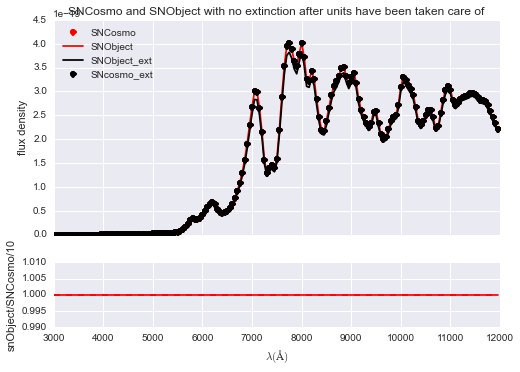

In [29]:
from utils import plotutils as pu
specfig, specax, diff =  pu.settwopanel(setdifflimits=[0.99,1.01])
specax.plot(wave, SN.flux(time=mjdobs, wave=wave),'ro', label='SNCosmo')
SN_blank.set_MWebv(0.)
sed = SN_blank.SNObjectSED(time=mjdobs, wavelen=wavenm)
specax.plot(wave, sed.flambda /10.,'r-', label='SNObject' )
sed_ext = SN.SNObjectSED(time=mjdobs, wavelen=wavenm)
specax.plot(wave, sed_ext.flambda /10.,'k-', label='SNObject_ext' )
#sn = SN.equivalentSNCosmoModel()
specax.plot(wave, sn.flux(wave=wave, time=mjdobs),'ko', label='SNcosmo_ext' )
specax.set_ylabel('flux density')
specax.legend(loc='best')
diff.set_xlabel(r'$\lambda (\AA)$')
diff.set_ylabel('snObject/SNCosmo/10')
diff.plot (wave, sed.flambda/SN.flux(time=mjdobs, wave=wave)/10.,'-r' )
diff.plot (wave, sed_ext.flambda/sn.flux(time=mjdobs, wave=wave)/10.,'--k' )
diff.plot(wave, sed_ext.flambda / sed.flambda, '-b')
diff.plot(wave, sn.flux(wave=wave, time=mjdobs) / SN.flux(time=mjdobs,
                                                          wave=wave), '--r')


specax.set_title('SNCosmo and SNObject with no extinction after units have been taken care of')

## Fluxes in BandPasses

In [30]:
wave = np.arange(10., 15000., 50.)
sed = SN.SNObjectSED(time=mjdobs, wavelen=wave)

In [31]:
sn = SN.equivalentSNCosmoModel()

In [32]:
from astropy.units import Unit
bp = sncosmo.Bandpass(wave=LSST_BandPass['r'].wavelen, 
                      trans=LSST_BandPass['r'].sb, 
                      wave_unit=Unit('nm'), name='lsst_r')

In [33]:
SN.catsimBandFluxes(bandpassobject=LSST_BandPass['r'], time=mjdobs)# , phiarray=pbase.phiArray)

1.9856857972304903e-11

In [34]:
sn.bandflux(time=mjdobs, band=bp, zp=0., zpsys='ab' )

1.9849721481051478e-11

In [35]:
SN.catsimBandMags(bandpassobject=LSST_BandPass['r'], time=mjdobs)

26.755223676263789

In [36]:
sn.bandmag(time=mjdobs, band=bp, magsys='ab' )

26.755613956520563

In [70]:
np.diff(SNSed.wavelen)[0]

5.0

In [78]:
def catsimManyFlux(ns, bandPassDict, observedBandPassInd=None):
    sed = ns.SNObjectSED(time=time, bandpass=bandPassDict)
    return sed  

In [ ]:
cat

In [77]:
SNSed.flambdaTofnu()
print np.shape(SNSed.fnu)
print np.shape(BP.phiArray)
# SNSed.manyFluxCalc(BP, wavelen_step=5.0, observedBandpassInd=None)

(180,)
(6, 8501)


In [62]:
help(SNSed.manyFluxCalc)

Help on method manyFluxCalc in module lsst.sims.photUtils.Sed:

manyFluxCalc(self, phiarray, wavelen_step, observedBandpassInd=None) method of lsst.sims.photUtils.Sed.Sed instance
    Calculate fluxes of a single sed for which fnu has been evaluated in a
    set of bandpasses for which phiarray has been set up to have the same
    wavelength grid as the SED in units of ergs/cm^2/sec. It is assumed
    that `self.fnu` is set before calling this method, and that phiArray
    has the same wavelength grid as the Sed.
    
    
    Parameters
    ----------
    phiarray: `np.ndarray`, mandatory
        phiarray corresponding to the list of bandpasses in which the band
        fluxes need to be calculated, in the same wavelength grid as the SED
    
    wavelen_step: `float`, mandatory
        the uniform grid size of the SED
    
    observedBandpassInd: list of integers, optional, defaults to None
        list of indices of phiarray corresponding to observed bandpasses,
        if None, th

In [37]:
import lsst.sims.photUtils.PhotometricParameters as PhotometricParameters
p = PhotometricParameters()
sed.calcADU(bandpass=LSST_BandPass['r'], photParams=p)

66.530334636154009

In [38]:
from lsst.sims.photUtils.SignalToNoise import calcSNR_sed

In [39]:
calcSNR_sed(SNObjectSED

SyntaxError: unexpected EOF while parsing (<ipython-input-39-63bbd698f859>, line 1)

(-1e-18, 1e+18)

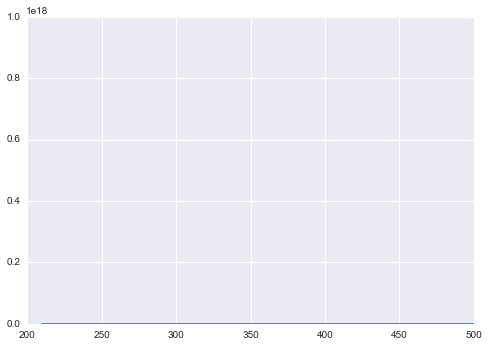

In [40]:
plt.plot(sed.wavelen, sed.flambda)
plt.xlim(200., 500.)
plt.ylim(-1.0e-18, 1.0e18)

In [41]:
mask = sed.flambda  < 0.

In [42]:
sed.badval

nan

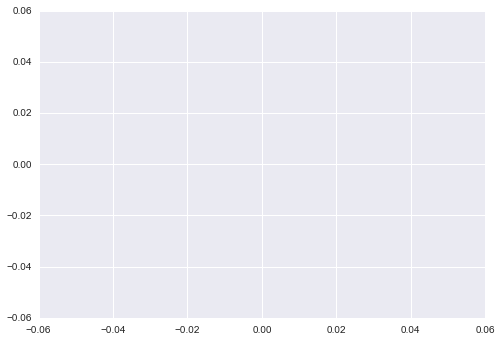

In [43]:
plt.plot(sed.wavelen[mask], sed.flambda[mask])

In [44]:
SN.catsimBandFluxes(bandpassobject=LSST_BandPass['r'], time=mjdobs)#, phiarray=pbase.phiArray)

1.9856857972304903e-11

In [45]:
help(sed.calcADU)

Help on method calcADU in module lsst.sims.photUtils.Sed:

calcADU(self, bandpass, photParams, wavelen=None, fnu=None) method of lsst.sims.photUtils.Sed.Sed instance
    Calculate the number of adu from camera, using sb and fnu.
    
    Given wavelen/fnu arrays or use self. Self or passed wavelen/fnu arrays will be unchanged.
    Calculating the AB mag requires the wavelen/fnu pair to be on the same grid as bandpass;
     (temporary values of these are used).
    
    @param [in] bandpass is an instantiation of the Bandpass class
    
    @param [in] photParams is an instantiation of the
    PhotometricParameters class that carries details about the
    photometric response of the telescope.
    
    @param [in] wavelen (optional) is the wavelength grid in nm
    
    @param [in] fnu (optional) is the flux in Janskys
    
    If wavelen and fnu are not specified, this will just use self.wavelen and
    self.fnu



In [46]:
import sncosmo

In [50]:
from astropy.units import Unit

In [51]:
bp = sncosmo.Bandpass(wave=LSST_BandPass['r'].wavelen, 
                      trans=LSST_BandPass['r'].sb, 
                      wave_unit=Unit('nm'), name='lsst_r')

In [52]:
SN.bandflux(time=mjdobs, band=bp, zp=8.9, zpsys='ab')

7.6863099953034164e-08

In [53]:
sn.bandflux(time=mjdobs, band=bp, zp=8.9, zpsys='ab')

7.2069982630684742e-08

In [54]:
dust = sncosmo.CCM89Dust()
sn = sncosmo.Model(source='salt2-extended', effects=[dust, dust], 
                   effect_names=['host', 'mw'],
                   effect_frames=['rest', 'obs'])

In [55]:
snstate.pop('ModelSource')

'salt2-extended'

In [56]:
#snstate.pop('_dec')
snstate.pop('_ra')

0.52359877559829882

In [57]:
snstate.pop('lsstmwebv')

KeyError: 'lsstmwebv'

In [58]:
snstate

{'MWE(B-V)': 0.02711203508079052,
 '_dec': -1.0471975511965976,
 'c': 0.35299999999999998,
 'hostebv': 0.0,
 'hostr_v': 3.1000000000000001,
 'mwebv': 0.0,
 'mwr_v': 3.1000000000000001,
 't0': 571181.0,
 'x0': 1.796112e-06,
 'x1': 2.6600000000000001,
 'z': 0.95999999999999996}

In [59]:
snstate.pop('MWE(B-V)')

0.02711203508079052

In [60]:
sn.set(**snstate)

KeyError: "Unknown parameter: '_dec'"

In [61]:
print sn

source:
  class      : SALT2Source
  name       : 'salt2-extended'
  version    : 1.0
  phases     : [-20, .., 50] days
  wavelengths: [300, .., 18000] Angstroms
effect (name='host' frame='rest'):
  class           : CCM89Dust
  wavelength range: [909.09, 33333.3] Angstroms
effect (name='mw' frame='obs'):
  class           : CCM89Dust
  wavelength range: [909.09, 33333.3] Angstroms
parameters:
  z       = 0.0
  t0      = 0.0
  x0      = 1.0
  x1      = 2.6600000000000001
  c       = 0.35299999999999998
  hostebv = 0.0
  hostr_v = 3.1000000000000001
  mwebv   = 0.0
  mwr_v   = 3.1000000000000001


In [ ]:
sn.set(mwebv=0.027112035)

In [ ]:
import lsst.sims.photUtils.PhotometricParameters as PhotometricParameters

In [ ]:
pp = PhotometricParameters(exptime=30.)

In [ ]:
SN.catsimADU(bandpassDict=pbase.bandpassDict, time=mjdobs, photParams=pp)

In [ ]:
SN.catsimBandMags(bandpassobject=bandpasslist[0], time=mjdobs + 23, phiarray=pbase.phiArray)

In [ ]:
print SN.summary()

In [ ]:
SN.get('t0') - mjdobs

In [ ]:
import sncosmo


In [ ]:
mysed = SN.SNObjectSED(time=mjdobs, bandpassobject=bandpasslist[0])

In [ ]:
mysed.flambdaTofnu()

In [ ]:
mysed.manyFluxCalc(phiarray=pbase.phiArray, wavelen_step=bandpasslist[0].wavelen_step)

In [ ]:
mysed.manyMagCalc(phiarray=pbase.phiArray, wavelen_step=bandpasslist[0].wavelen_step)

In [ ]:
max(map(lambda x: max(x.sb), bandpasslist))

In [ ]:
sns.set()
specfig, specax = plt.subplots() # pu.settwopanel(setdifflimits=[0.09,1.4])
# specax.plot(wave, SN.flux(time=mjdobs, wave=wave))
# sed = SN.SNObjectSED(time=mjdobs, wavelen=wavenm)
specax.plot(mysed.wavelen, mysed.flambda, '-k', lw=2.0)
specax.set_ylabel('flux density')
specax.set_xlabel(r'$\lambda (nm)$')
ymin, ymax = plt.ylim()
# filternames = ['u', 'g', 'r', 'i', 'z', 'y']
# bp = map(lambda x: pbase.bandpassDict[x], filternames)
#maxsb = max(map(lambda x: max(pbase.bandpassDict[x].sb), filternames))
maxsb = max(map(lambda x: max(x.sb), bandpasslist))
r = 0.8 / (maxsb / ymax ) 
trans = 0.2
specax.fill(bandpasslist[0].wavelen, bandpasslist[0].sb *r, alpha=trans)
specax.fill(bandpasslist[0].wavelen, bandpasslist[1].sb *r, alpha=trans)
specax.fill(bandpasslist[0].wavelen, bandpasslist[2].sb *r, alpha=trans)
specax.fill(bandpasslist[0].wavelen, bandpasslist[3].sb *r, alpha=trans)
specax.fill(bandpasslist[0].wavelen, bandpasslist[4].sb *r, alpha=trans)
specax.fill(bandpasslist[0].wavelen, bandpasslist[5].sb *r, alpha=trans)
# specax.set_ylim(-1.0e-20,1.0e-20)

In [ ]:
SN.set(mwebv=SN.ebvofMW)

In [ ]:
SN.bandflux(band=['desg', 'desr', 'desi', 'desz'], time=mjdobs, zpsys='ab', zp=0. )

In [ ]:
SN.bandmag(band=['desg', 'desr', 'desi', 'desz'], time=mjdobs, magsys='ab')

In [ ]:
for key in SN.SNstate.keys():
    if SN.SNstate[key] != sn.SNstate[key]:
        print '============================'
        print key
        print '____________________________'
        print SN.SNstate[key],'\n---------------------------\n', sn.SNstate[key]
        print '++++++++++++++++++++++++++++'

In [ ]:
print SN

In [ ]:
print mjdobs

In [ ]:
phase = (mjdobs - SN.parameters[SN.param_names.index('t0')]) / (SN.parameters[SN.param_names.index('z')]+ 1.)

In [ ]:
print phase

In [ ]:
SN.param_names.index('t0')

In [ ]:
import lsst.sims.photUtils.PhotometricParameters as PhotometricParameters

In [ ]:
pp = PhotometricParameters(exptime=30.)

In [ ]:
pbase.setupPhiArray_dict()

In [ ]:
phiarray, dlambda = mysed.setupPhiArray(bandpasslist)

In [ ]:
phiarray.shape

In [ ]:
SN.catsimADU(bandpassobject=bandpasslist[0], photParams=pp, time=mjdobs)

# Scratch

Unfortunately, there is no way to establish equality: